In [172]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

import tensorflow as tf
!pip install keras-tuner -q

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [173]:
df=pd.read_csv("GoogleStockPrices.csv")

In [174]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2015-01-02 16:00:00,26.63,26.79,26.39,26.48,1327870
1,2015-01-05 16:00:00,26.36,26.40,25.89,25.97,2059119
2,2015-01-06 16:00:00,26.02,26.06,25.28,25.33,2731813
3,2015-01-07 16:00:00,25.55,25.57,25.18,25.26,2345875
4,2015-01-08 16:00:00,25.08,25.38,24.75,25.35,3662224


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2516 non-null   object 
 1   Open    2516 non-null   float64
 2   High    2516 non-null   float64
 3   Low     2516 non-null   float64
 4   Close   2516 non-null   float64
 5   Volume  2516 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 118.1+ KB


In [176]:
#chnage Date type from object to datetime64[ns]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [177]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02 16:00:00,26.63,26.79,26.39,26.48,1327870
2015-01-05 16:00:00,26.36,26.40,25.89,25.97,2059119
2015-01-06 16:00:00,26.02,26.06,25.28,25.33,2731813
2015-01-07 16:00:00,25.55,25.57,25.18,25.26,2345875
2015-01-08 16:00:00,25.08,25.38,24.75,25.35,3662224


In [178]:
print(df.describe())    # Statistics like mean, min, max
print(df.info())        # Data types and missing values

              Open         High          Low        Close        Volume
count  2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03
mean     82.678052    83.560413    81.831208    82.714996  8.797572e+06
std      43.716508    44.214494    43.257158    43.735891  1.365305e+07
min      24.960000    25.010000    24.550000    24.850000  4.656380e+05
25%      47.367500    47.637500    47.000000    47.380000  1.398751e+06
50%      64.530000    65.045000    63.935000    64.710000  1.876044e+06
75%     119.665000   121.042500   118.592500   119.700000  6.056782e+06
max     197.250000   201.420000   194.980000   196.660000  1.194550e+08
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-01-02 16:00:00 to 2024-12-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2516 non-null   float64
 1   High    2516 non-null   float64
 2   Low     2516 non-null   float64
 3   Close   2516 non-nul

In [179]:
# Count of null values
print(df.isnull().sum())

# Percentage of missing values
print((df.isnull().mean() * 100).round(2))

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Open      0.0
High      0.0
Low       0.0
Close     0.0
Volume    0.0
dtype: float64


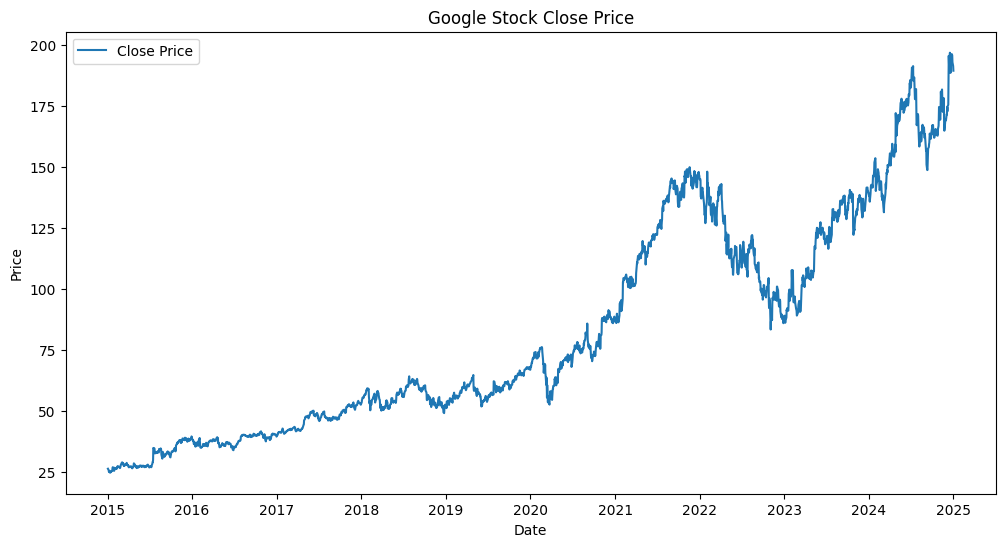

In [180]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price')
plt.title('Google Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

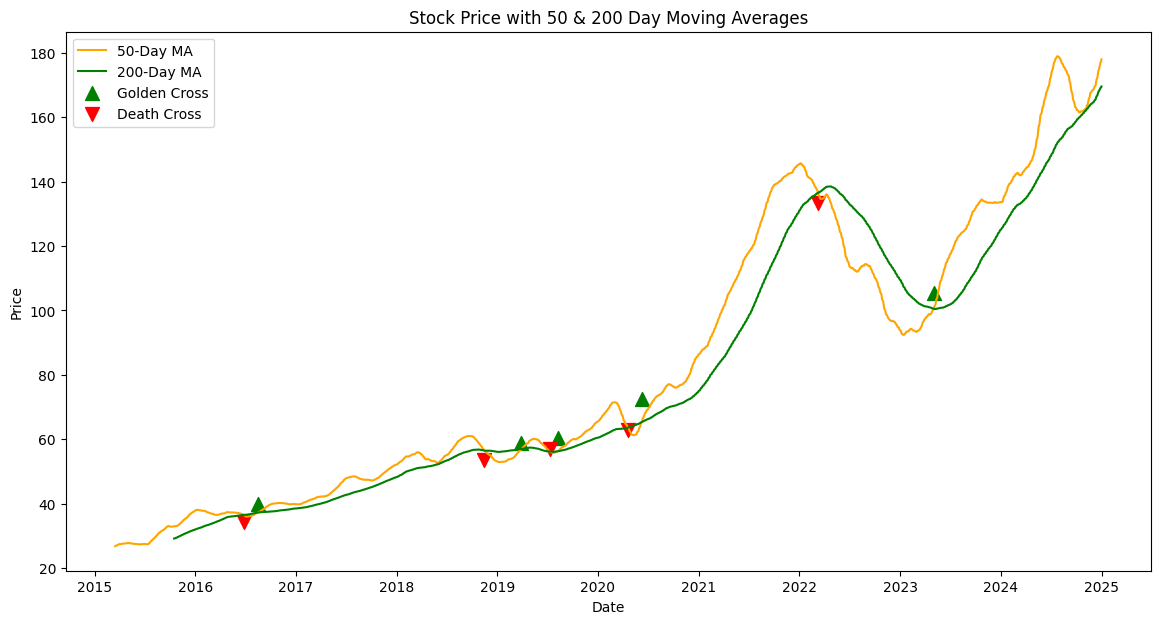

In [181]:
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(14,7))
#plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(df['MA50'], label='50-Day MA', color='orange')
plt.plot(df['MA200'], label='200-Day MA', color='green')

# Highlight Golden Cross and Death Cross
golden_cross = (df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1))
death_cross = (df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1))

plt.scatter(df.index[golden_cross], df['Close'][golden_cross], marker='^', color='g', s=100, label='Golden Cross')
plt.scatter(df.index[death_cross], df['Close'][death_cross], marker='v', color='r', s=100, label='Death Cross')

plt.title('Stock Price with 50 & 200 Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


<Axes: title={'center': 'Daily Returns'}, xlabel='Date'>

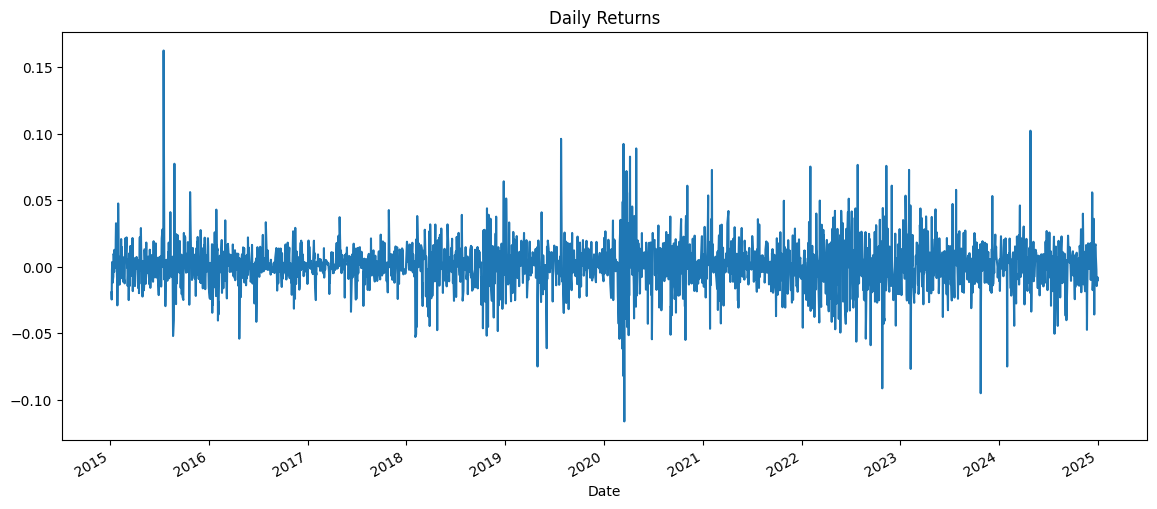

In [182]:
df['Daily_Return'] = df['Close'].pct_change()
df['Daily_Return'].plot(figsize=(14,6), title='Daily Returns')

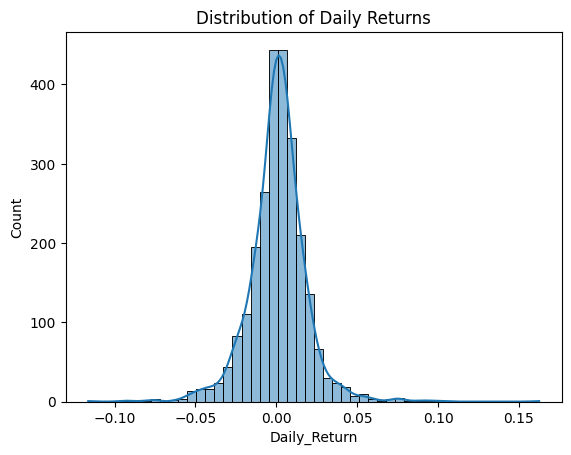

In [183]:
sns.histplot(df['Daily_Return'].dropna(), bins=50, kde=True)
plt.title("Distribution of Daily Returns")
plt.show()

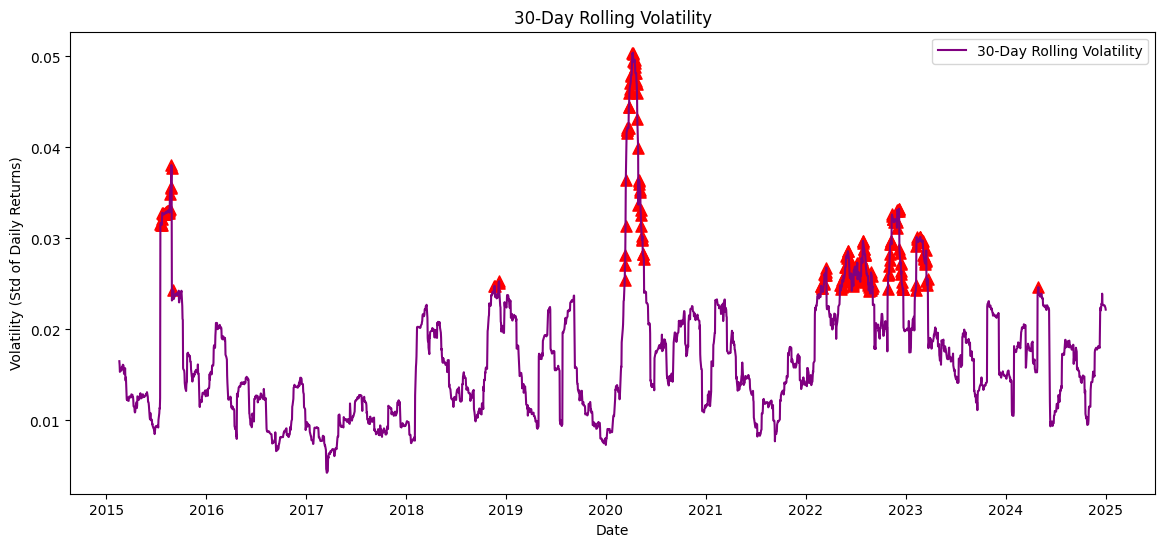

In [184]:
# Calculate 30-day rolling volatility
df['Volatility30'] = df['Daily_Return'].rolling(window=30).std()

plt.figure(figsize=(14,6))
plt.plot(df['Volatility30'], color='purple', label='30-Day Rolling Volatility')
plt.title('30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (Std of Daily Returns)')
plt.legend()

# Highlight high volatility periods
high_vol = df['Volatility30'] > df['Volatility30'].quantile(0.9)  # top 10% volatility
plt.scatter(df.index[high_vol], df['Volatility30'][high_vol], color='red', marker='^', s=65, label='High Volatility')

plt.show()

<Axes: title={'center': 'Cumulative Returns'}, xlabel='Date'>

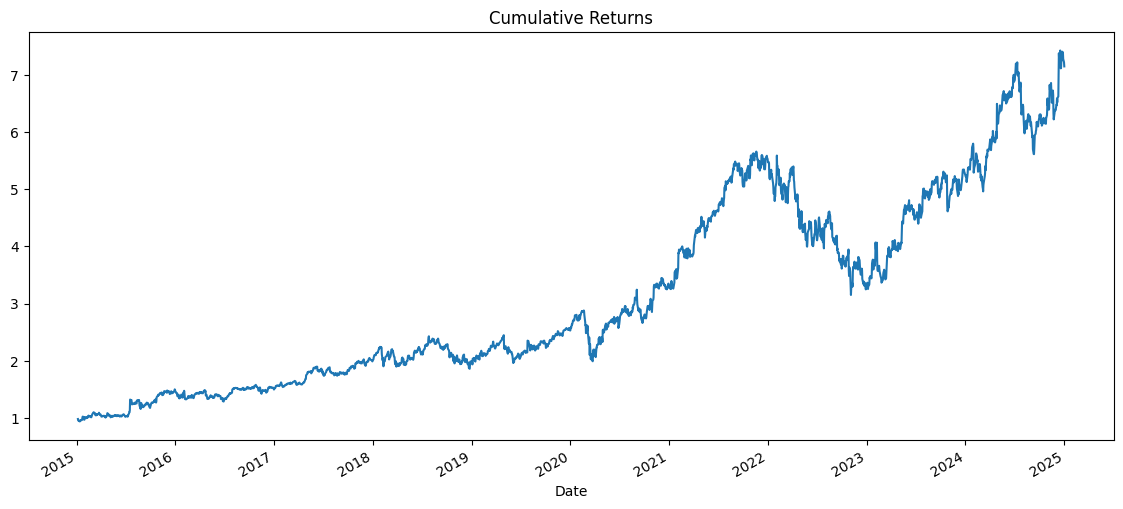

In [185]:
df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod()
df['Cumulative_Return'].plot(figsize=(14,6), title='Cumulative Returns')

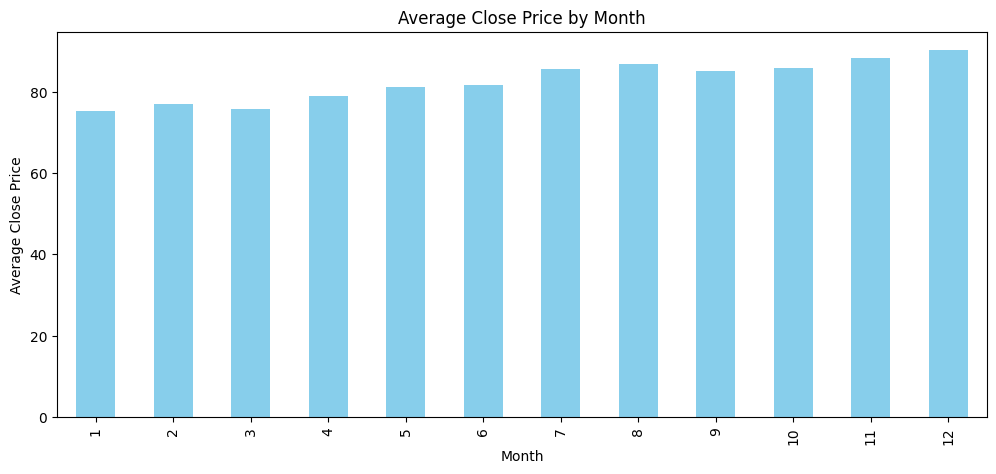

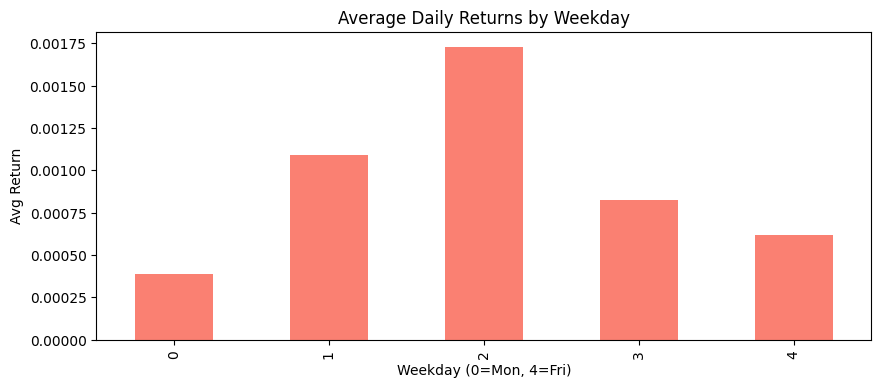

In [186]:
# Extract Month and Weekday
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday
df['Year'] = df.index.year

# monthly average

monthly_avg = df.groupby('Month')['Close'].mean()

plt.figure(figsize=(12,5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title("Average Close Price by Month")
plt.xlabel("Month")
plt.ylabel("Average Close Price")
plt.show()



# weekday average returns
weekday_avg = df.groupby('Weekday')['Daily_Return'].mean()

plt.figure(figsize=(10,4))
weekday_avg.plot(kind='bar', color='salmon')
plt.title("Average Daily Returns by Weekday")
plt.xlabel("Weekday (0=Mon, 4=Fri)")
plt.ylabel("Avg Return")
plt.show()


In [187]:
df

,Open,High,Low,Close,Volume,MA50,MA200,Daily_Return,Volatility30,Cumulative_Return,Month,Weekday,Year
Date,,,,,,,,,,,,,
2015-01-02 16:00:00,26.63,26.79,26.39,26.48,1327870,NaN,NaN,NaN,NaN,NaN,1,4,2015
2015-01-05 16:00:00,26.36,26.40,25.89,25.97,2059119,NaN,NaN,-0.019260,NaN,0.980740,1,0,2015
2015-01-06 16:00:00,26.02,26.06,25.28,25.33,2731813,NaN,NaN,-0.024644,NaN,0.956571,1,1,2015
2015-01-07 16:00:00,25.55,25.57,25.18,25.26,2345875,NaN,NaN,-0.002764,NaN,0.953927,1,2,2015
2015-01-08 16:00:00,25.08,25.38,24.75,25.35,3662224,NaN,NaN,0.003563,NaN,0.957326,1,3,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24 13:05:00,194.84,196.11,193.78,196.11,10403259,175.6774,168.45680,0.007604,0.022638,7.405967,12,1,2024
2024-12-26 16:00:00,195.15,196.75,194.38,195.60,12057210,176.2802,168.74230,-0.002601,0.022648,7.386707,12,3,2024
2024-12-27 16:00:00,194.95,195.32,190.65,192.76,18891362,176.8322,169.00715,-0.014519,0.022633,7.279456,12,4,2024


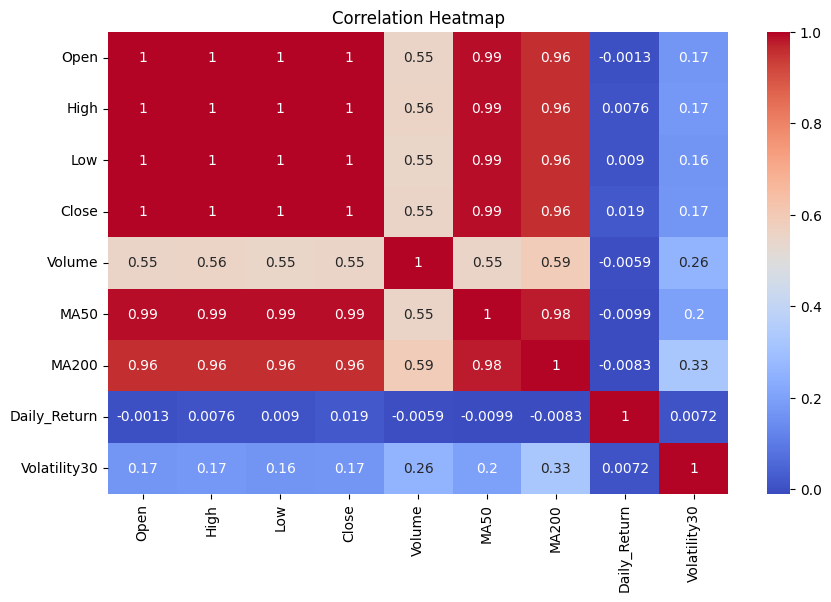

In [188]:
corr_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA50', 'MA200', 'Daily_Return', 'Volatility30']

plt.figure(figsize=(10,6))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [189]:
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']
)])

fig.update_layout(
    title={'text': 'Candlestick Chart', 'x': 0.5, 'xanchor': 'center'},
    xaxis_rangeslider_visible=False,

    height=500,
    width=1200,
)

fig.show()


In [190]:
df

,Open,High,Low,Close,Volume,MA50,MA200,Daily_Return,Volatility30,Cumulative_Return,Month,Weekday,Year
Date,,,,,,,,,,,,,
2015-01-02 16:00:00,26.63,26.79,26.39,26.48,1327870,NaN,NaN,NaN,NaN,NaN,1,4,2015
2015-01-05 16:00:00,26.36,26.40,25.89,25.97,2059119,NaN,NaN,-0.019260,NaN,0.980740,1,0,2015
2015-01-06 16:00:00,26.02,26.06,25.28,25.33,2731813,NaN,NaN,-0.024644,NaN,0.956571,1,1,2015
2015-01-07 16:00:00,25.55,25.57,25.18,25.26,2345875,NaN,NaN,-0.002764,NaN,0.953927,1,2,2015
2015-01-08 16:00:00,25.08,25.38,24.75,25.35,3662224,NaN,NaN,0.003563,NaN,0.957326,1,3,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24 13:05:00,194.84,196.11,193.78,196.11,10403259,175.6774,168.45680,0.007604,0.022638,7.405967,12,1,2024
2024-12-26 16:00:00,195.15,196.75,194.38,195.60,12057210,176.2802,168.74230,-0.002601,0.022648,7.386707,12,3,2024
2024-12-27 16:00:00,194.95,195.32,190.65,192.76,18891362,176.8322,169.00715,-0.014519,0.022633,7.279456,12,4,2024


In [191]:
#Make copy
df_copy = df.copy()

#Select target column
target = "Close"

series = df_copy[target]

#Train-test split
train_size = int(len(df_copy) * 0.8)

train_df = df_copy.iloc[:train_size].copy()
test_df = df_copy.iloc[train_size:].copy()

#Extract train/test series
train_series = train_df[target]
test_series  = test_df[target]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Df copy shape:", df_copy.shape)

Train shape: (2012, 13)
Test shape: (504, 13)
Df copy shape: (2516, 13)


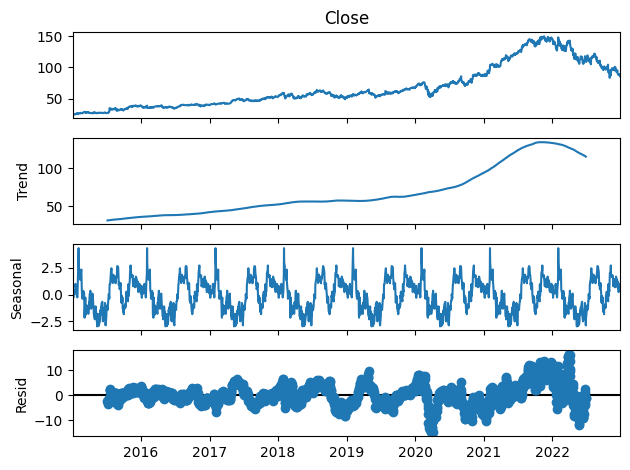

In [192]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(train_series, model='additive', period=252)
decomp.plot()
plt.show()

In [193]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name='Series'):
    s = series.dropna()
    result = adfuller(s)
    print(f'ADF Statistic ({name}): {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print("--> Stationary\n" if result[1] <= 0.05 else "--> Non-stationary\n")

# Use your train_series
adf_test(train_series, 'Original Series')
adf_test(train_series.diff(), '1st Difference')
adf_test(train_series.diff().diff(), '2nd Difference')


ADF Statistic (Original Series): -1.1723
p-value: 0.6854
--> Non-stationary

ADF Statistic (1st Difference): -10.1638
p-value: 0.0000
--> Stationary

ADF Statistic (2nd Difference): -14.9596
p-value: 0.0000
--> Stationary



In [194]:
def find_d(series, max_diff=5):
    current_series = series
    for d in range(max_diff+1):
        p_value = adfuller(current_series.dropna())[1]
        if p_value <= 0.05:
            return d
        current_series = current_series.diff()
    return max_diff  # fallback if not stationary

d = find_d(train_df['Close'])
print(f"Number of differences needed for stationarity (d): {d}")


Number of differences needed for stationarity (d): 1


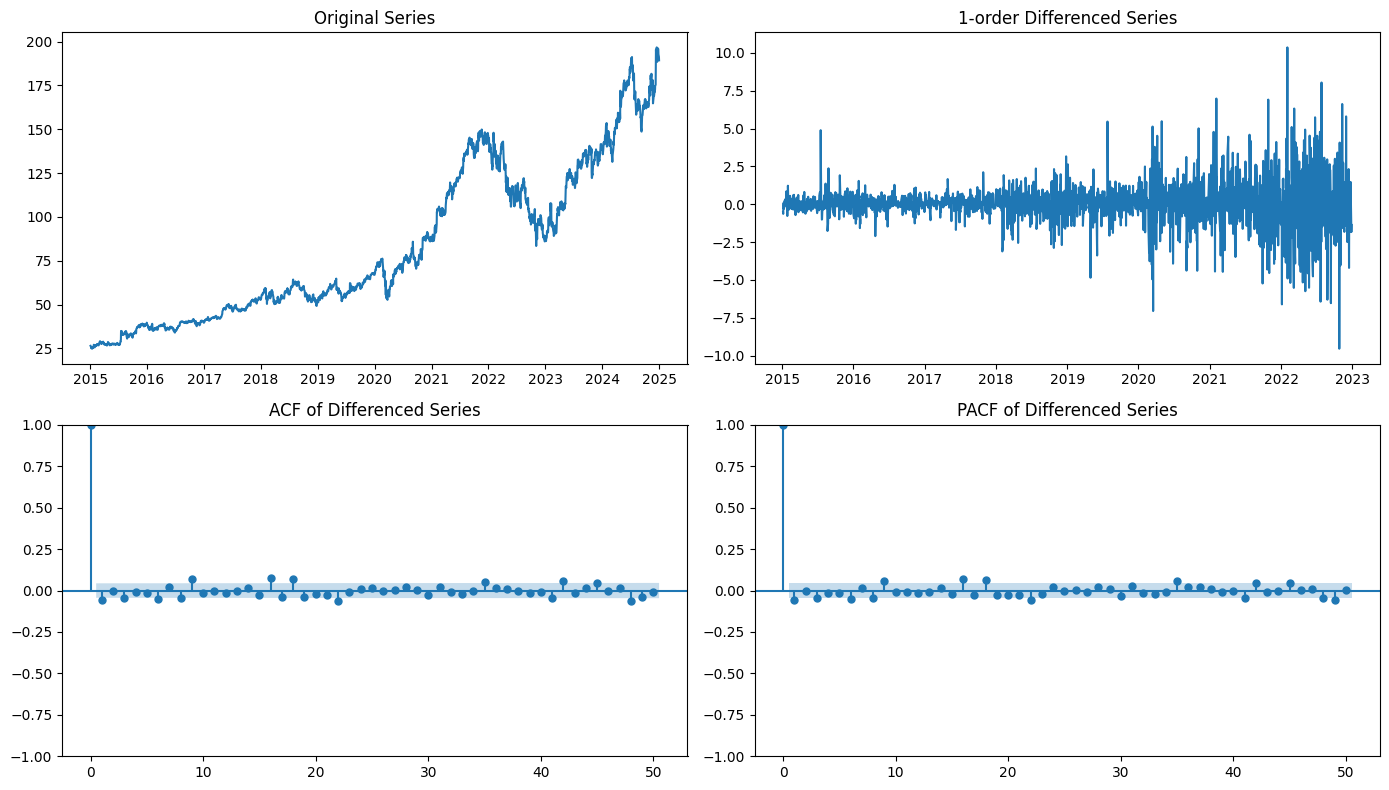

In [195]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Differencing as needed
series_to_use = train_df['Close'].copy()
for i in range(d):
    series_to_use = series_to_use.diff()

# Plot Original & Differenced Series
fig, axes = plt.subplots(2,2, figsize=(14,8))

# Original
axes[0,0].plot(df['Close']); axes[0,0].set_title("Original Series")

# Differenced
axes[0,1].plot(series_to_use); axes[0,1].set_title(f"{d}-order Differenced Series")

# ACF & PACF
plot_acf(series_to_use.dropna(), ax=axes[1,0], lags=50)
axes[1,0].set_title("ACF of Differenced Series")

plot_pacf(series_to_use.dropna(), ax=axes[1,1], lags=50)
axes[1,1].set_title("PACF of Differenced Series")

plt.tight_layout()
plt.show()

In [196]:
def suggest_pq(series, nlags=50):
    n = len(series.dropna())
    conf_int = 2/np.sqrt(n)  # 95% CI

    acf_vals = acf(series.dropna(), nlags=nlags)
    pacf_vals = pacf(series.dropna(), nlags=nlags)

    # For PACF: find first significant peak (absolute value above conf_int)
    p_candidates = np.where(np.abs(pacf_vals[1:]) > conf_int)[0] + 1
    q_candidates = np.where(np.abs(acf_vals[1:]) > conf_int)[0] + 1

    # Pick the largest significant lag before decay
    p = p_candidates[0] if len(p_candidates) > 0 else 0
    q = q_candidates[0] if len(q_candidates) > 0 else 0

    # Optional: ignore very small lags (like lag=1), pick next peak
    if p == 1 and len(p_candidates) > 1:
        p = p_candidates[1]
    if q == 1 and len(q_candidates) > 1:
        q = q_candidates[1]

    return p, q

p, q = suggest_pq(series_to_use)
print(f"Suggested ARIMA hyperparameters: p={p}, d={d}, q={q}")

Suggested ARIMA hyperparameters: p=3, d=1, q=3


In [197]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_df['Close'], order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2012
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3546.850
Date:                Fri, 12 Dec 2025   AIC                           7107.700
Time:                        05:34:49   BIC                           7146.945
Sample:                             0   HQIC                          7122.106
                               - 2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7971      0.031    -25.365      0.000      -0.859      -0.735
ar.L2          0.8796      0.019     45.204      0.000       0.841       0.918
ar.L3          0.8993      0.031     28.650      0.0

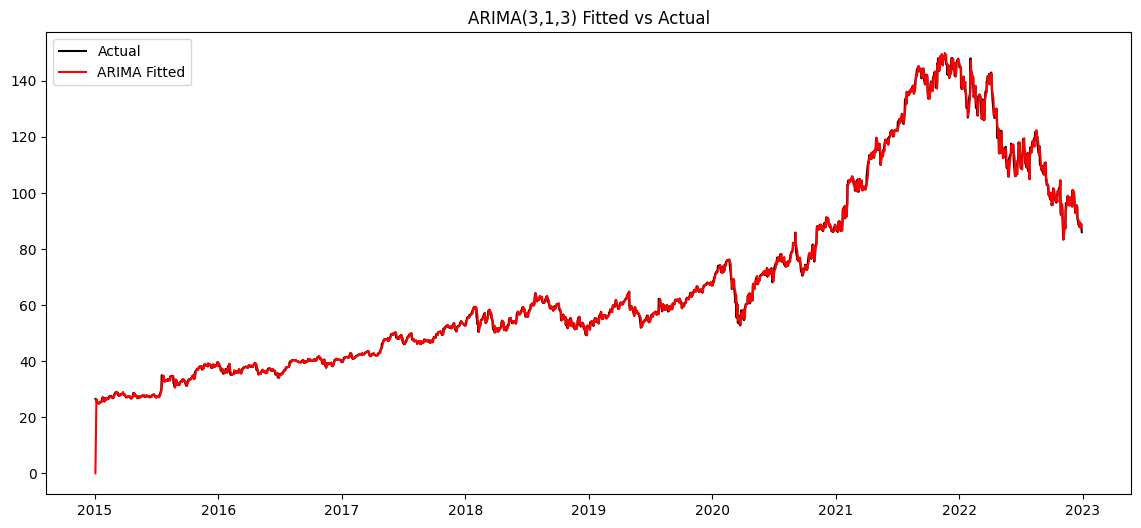

In [198]:
train_df['ARIMA_Fitted'] = model_fit.fittedvalues

plt.figure(figsize=(14,6))
plt.plot(train_df['Close'], color="black",label="Actual")
plt.plot(train_df['ARIMA_Fitted'], color='red', label="ARIMA Fitted")
plt.title(f"ARIMA({p},{d},{q}) Fitted vs Actual")
plt.legend()
plt.show()


In [199]:
# Original series
actual = train_df['Close']

# Fitted values
fitted = model_fit.fittedvalues

# Align lengths
if len(fitted) < len(actual):
    actual_aligned = actual.iloc[-len(fitted):]
elif len(fitted) > len(actual):
    fitted = fitted.iloc[-len(actual):]
    actual_aligned = actual
else:
    actual_aligned = actual

# Now compute metrics safely
mae = mean_absolute_error(actual_aligned, fitted)
rmse = np.sqrt(mean_squared_error(actual_aligned, fitted))
mape = np.mean(np.abs((actual_aligned - fitted)/actual_aligned))*100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.8868
RMSE: 1.5298
MAPE: 1.27%


In [200]:
# Number of steps = length of test_df
steps = len(test_df)

# Forecast using fitted ARIMA
forecast = model_fit.forecast(steps=steps)

# Align forecast index with test_df
forecast.index = test_df.index

print(forecast)

Date
2022-12-29 16:00:00    85.902578
2022-12-30 16:00:00    85.909368
2023-01-03 16:00:00    85.860527
2023-01-04 16:00:00    85.799833
2023-01-05 16:00:00    85.811357
                         ...    
2024-12-24 13:05:00    78.763672
2024-12-26 16:00:00    78.760394
2024-12-27 16:00:00    78.757132
2024-12-30 16:00:00    78.753886
2024-12-31 16:00:00    78.750656
Name: predicted_mean, Length: 504, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



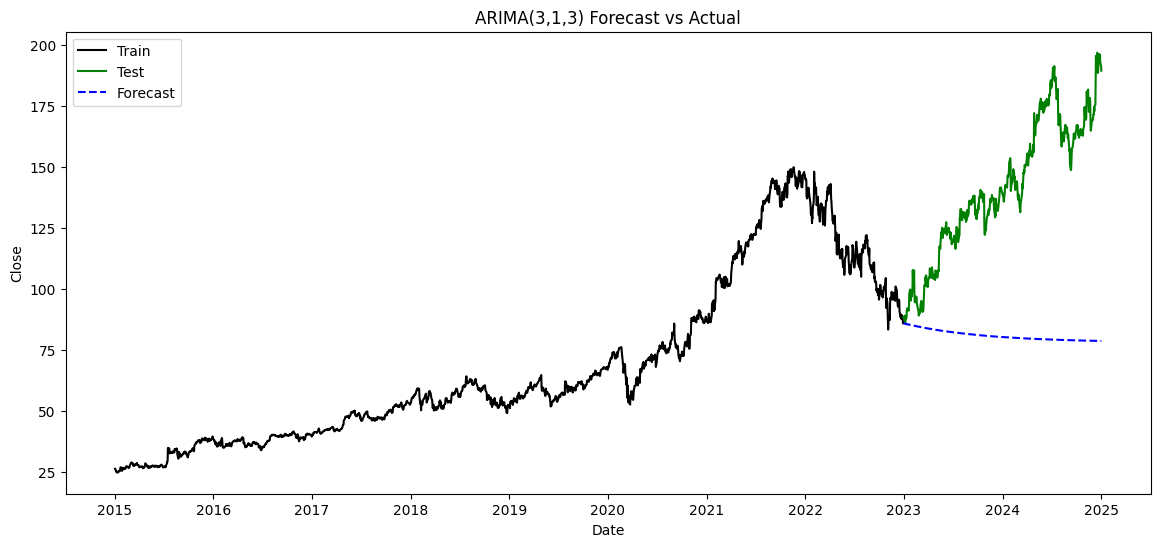

In [201]:
plt.figure(figsize=(14,6))

# Training data
plt.plot(train_df['Close'], label='Train', color='black')

# Test data
plt.plot(test_df['Close'], label='Test', color='green')

# Forecast
plt.plot(forecast, label='Forecast', color='blue', linestyle='--')

plt.title(f"ARIMA({p},{d},{q}) Forecast vs Actual")
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


In [202]:
mae = mean_absolute_error(test_df['Close'], forecast)
rmse = np.sqrt(mean_squared_error(test_df['Close'], forecast))
mape = np.mean(np.abs((test_df['Close'] - forecast)/test_df['Close']))*100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 60.1903
RMSE: 67.0194
MAPE: 39.88%


In [203]:
train_data = train_df['Close'].values.reshape(-1,1)
test_data = test_df['Close'].values.reshape(-1,1)

# Scale data to [0,1] using train scaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)  # use same scaler!

# Function to create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60

# Create sequences for train and test
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(np.concatenate((train_scaled[-seq_length:], test_scaled), axis=0), seq_length)
# Explanation: Concatenate last 'seq_length' points from train with test for proper sequence creation

# Reshape for CNN-LSTM: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (1952, 60, 1)
X_test shape: (504, 60, 1)


In [204]:
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu',input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences = False),
    Dropout(0.2),
    Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [205]:
model.compile(
    optimizer= 'adam',
    loss='mse'
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 56, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,435 (91.54 KB)

 Trainable params: 23,435 (91.54 KB)

 Non-trainable params: 0 (0.00 B)

In [206]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0492 - val_loss: 0.0020
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0

In [207]:
y_pred = model.predict(X_test)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_scaled = scaler.inverse_transform(y_pred)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [208]:
def adjusted_r2(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adj_r2 = 1 - (1-r2)*(n-1)/(n-n_features-1)
    return adj_r2

adj_r2 = adjusted_r2(y_test_scaled, y_pred_scaled, n_features=1)
print("Adjusted R²:", round(adj_r2, 2))

Adjusted R²: 0.96


In [209]:
rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 5.41579714815654
MAE: 4.272193416413807


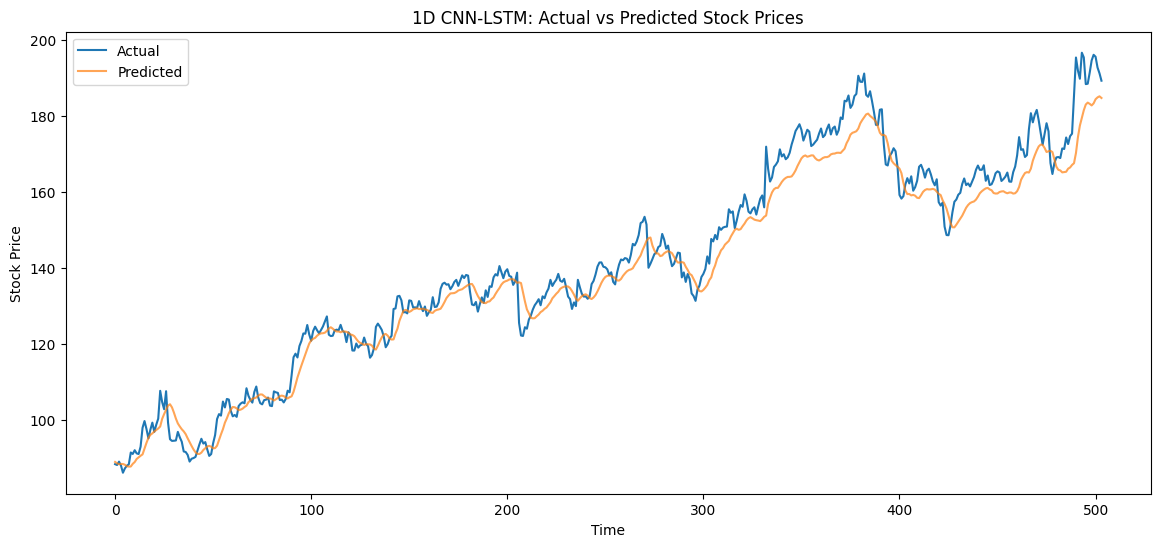

In [210]:
plt.figure(figsize=(14,6))
plt.plot(y_test_scaled, label='Actual')
plt.plot(y_pred_scaled, label='Predicted', alpha=0.7)
plt.title("1D CNN-LSTM: Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

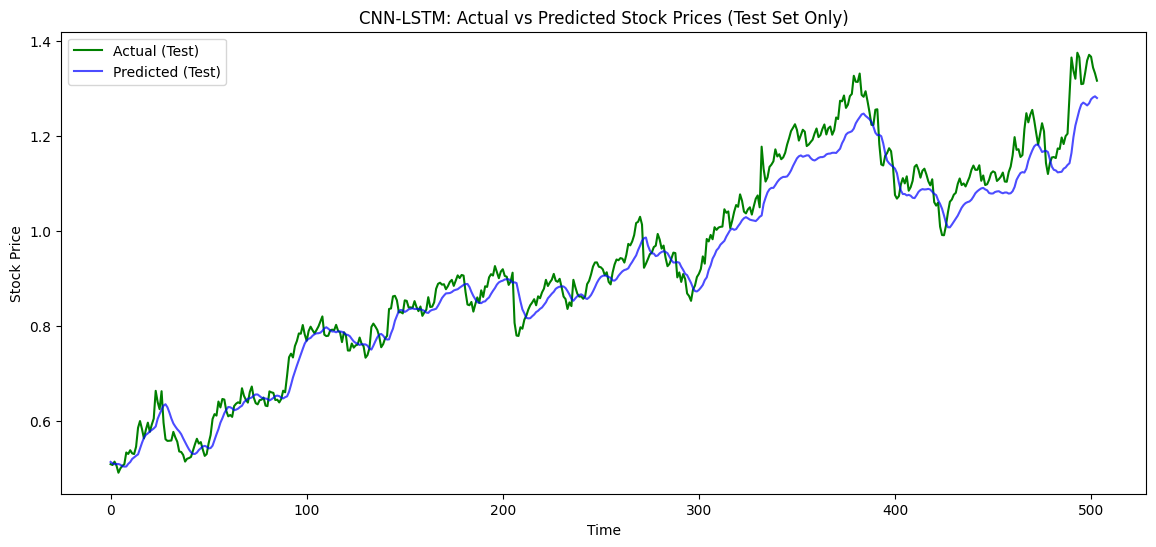

In [211]:
plt.figure(figsize=(14,6))
plt.plot(y_test, label='Actual (Test)', color='green')
plt.plot(y_pred, label='Predicted (Test)', color='blue', alpha=0.7)
plt.title("CNN-LSTM: Actual vs Predicted Stock Prices (Test Set Only)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


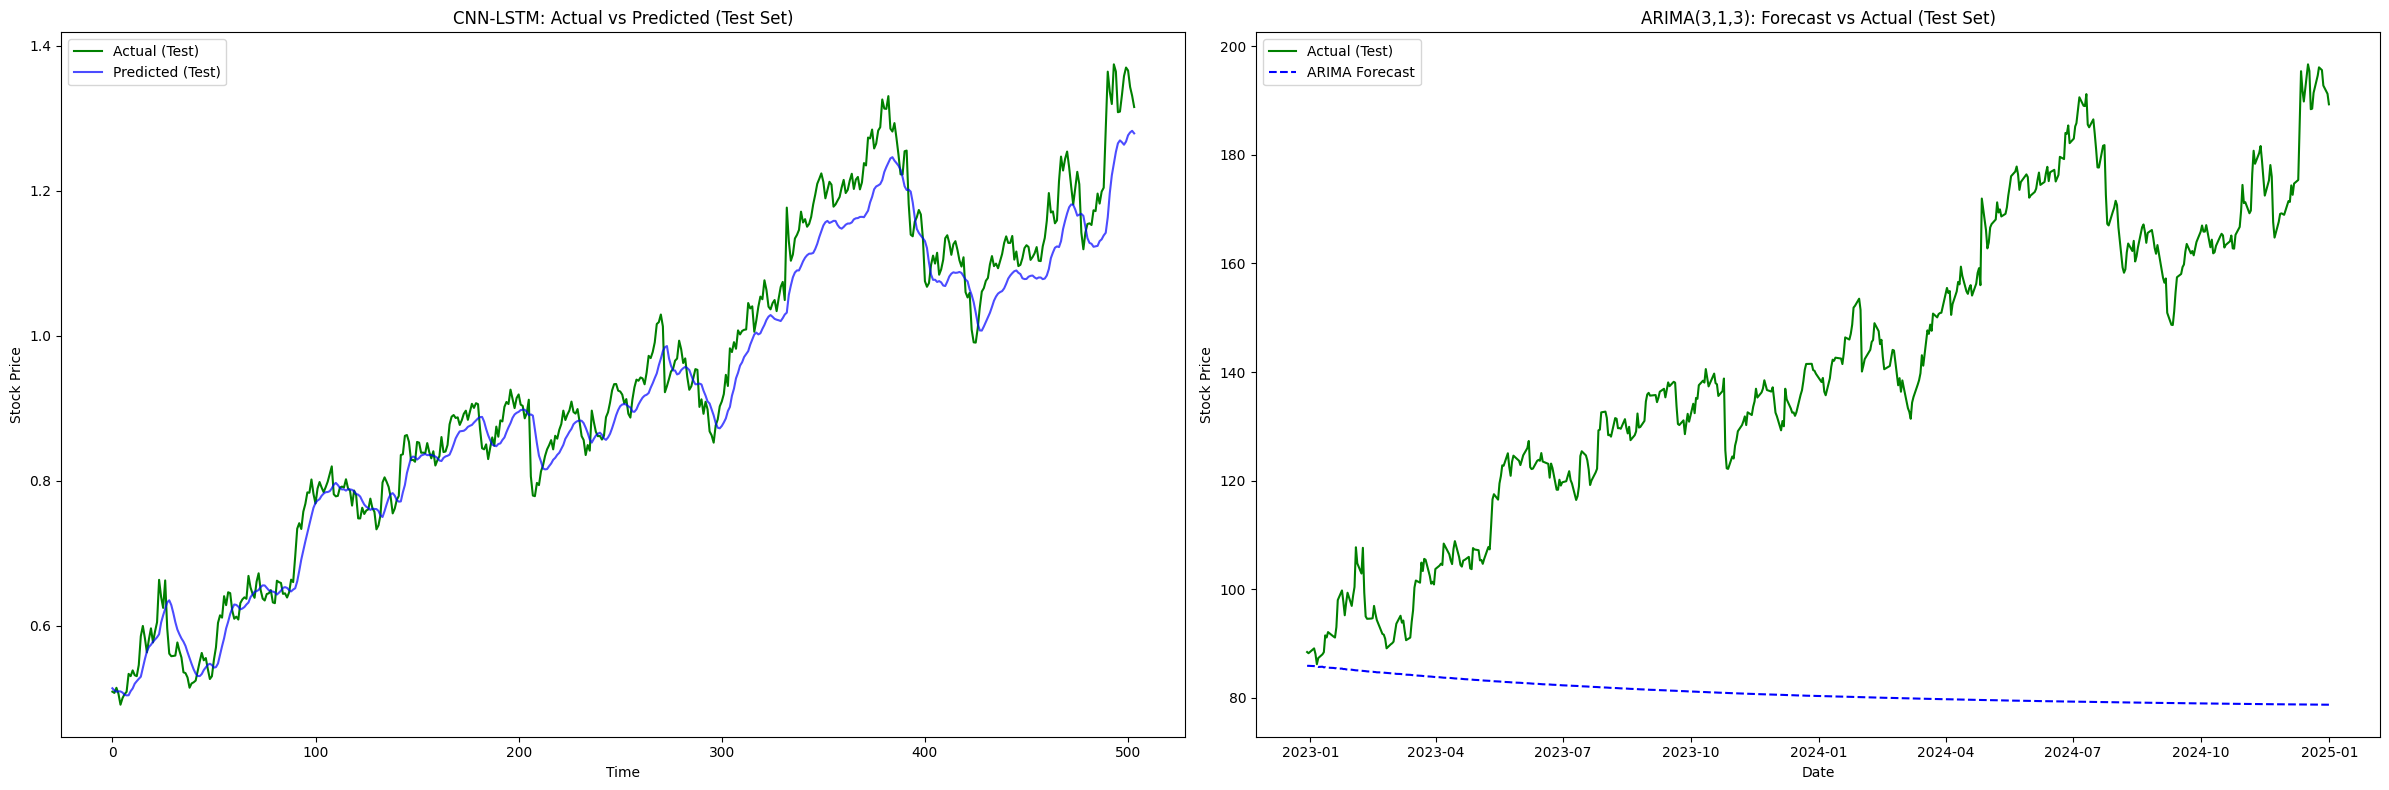

In [212]:
# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(24,8))

# Left: CNN-LSTM Actual vs Predicted
axs[0].plot(y_test, label='Actual (Test)', color='green')
axs[0].plot(y_pred, label='Predicted (Test)', color='blue', alpha=0.7)
axs[0].set_title("CNN-LSTM: Actual vs Predicted (Test Set)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Stock Price")
axs[0].legend()

# Right: ARIMA Actual vs Forecast
axs[1].plot(test_df['Close'], label='Actual (Test)', color='green')
axs[1].plot(forecast, label='ARIMA Forecast', color='blue', linestyle='--')
axs[1].set_title(f"ARIMA({p},{d},{q}): Forecast vs Actual (Test Set)")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Stock Price")
axs[1].legend()

plt.tight_layout()
plt.show()


In [213]:
from sklearn.metrics import r2_score

train_pred = model.predict(X_train)
test_pred  = model.predict(X_test)

train_r2 = r2_score(y_train, train_pred)
test_r2  = r2_score(y_test, test_pred)

print("Train R2:", train_r2)
print("Test R2:", test_r2)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train R2: 0.9950035166917331
Test R2: 0.961543349640087
